In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt
data = pd.read_csv('train.csv')

In [2]:
# Use DataFrame.head() and DataFrame.tail() to view the top and bottom rows of the frame respectively:
data.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

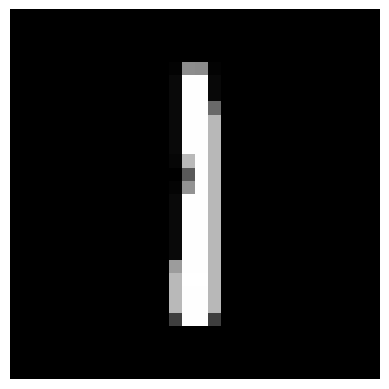

In [3]:
data = np.array(data)

def plot_mnist_image(image_array):
    image = image_array.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

plot_mnist_image(data[2, 1:])

In [4]:
m, n = data.shape
print(m,n)

42000 785


In [5]:
np.random.shuffle(data) # Shuffles all the individual rows
data_dev = data[0:1000].T #Take the first 1000 rows, and transpose the matrix to get 1000 examples as column vectors
data_dev

array([[6, 1, 9, ..., 3, 5, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
Y_dev = data_dev[0] #Takes the first row, which contains all of the answers to the numbers (the Y is what we want)

In [7]:
X_dev = data_dev[1:]
X_dev = X_dev / 255.

In [8]:
X_dev = X_dev.reshape(28,28,1000)
print(X_dev.shape)

(28, 28, 1000)


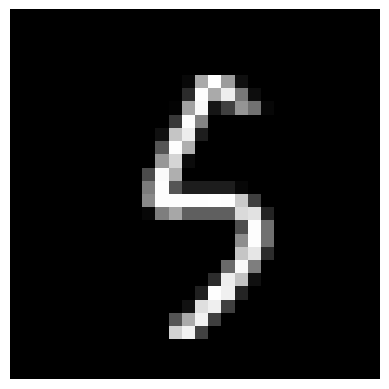

5


In [9]:
# print(X_dev[:,:,1])
plot_mnist_image(X_dev[:,:,6])
print(Y_dev[6])

In [10]:
data_train = data[1000:m].T
Y_train = data_train[0]

In [11]:
X_train= data_train[1:n] #Takes all of the data corresponding to all of the entries
X_train = X_train.reshape(28,28,41000)
X_dev = X_dev / 255.

In [12]:
def max_pooling(input_data):
    # 24, 24, 2
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 # 12
    output_width = input_width // 2 # 12
    output_depth = input_depth # 2 - depth stays the same

    # Initialize the output array and array to store indices
    output_data = np.zeros((output_height, output_width, output_depth))
    indices = np.zeros((output_height, output_width, output_depth, 2), dtype=int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val = np.max(region)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_indices = np.unravel_index(np.argmax(region), region.shape)
                # Store the indices relative to the region and convert to global indices
                indices[h, w, d] = [h*2 + max_indices[0], w*2 + max_indices[1]]

    return output_data, indices


In [32]:
def der_ReLU(Z):
  return Z > 0

def ReLU(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def softmax(Z):
    # Apply softmax column-wise
    exp_Z = np.exp(Z - np.max(Z, axis=0))  # Subtracting the maximum value in each column to avoid overflow
    return exp_Z / np.sum(exp_Z, axis=0)


# def sigmoid_prime(z):
#   return sigmoid(z)*(1-sigmoid(z))

# def sigmoid(z):
#     # Compute the sigmoid function element-wise
#     return 1.0 / (1.0 + np.exp(-z))

In [ ]:
# Initalize layer
def params():
    layer_weights = np.random.rand(5,5,2) - 0.5 #(5,5,2)
    layer_bias = np.random.rand(24,24,2) - 0.5 #(24,24,2)
    layer_output = np.zeros((24,24,2)) #(24,24,2)
    fc_weights = np.random.rand(10, 288) - 0.5 #(10, 288)
    fc_bias = np.random.rand(10,1) - 0.5 #(10, 1)
    fc_bias = fc_bias.reshape(10, 1)
    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias


In [63]:
import numpy as np

def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(2 / np.sum(shape[:-1]))

def params():
    # Initialize convolutional layer weights with Xavier initialization
    layer_weights = xavier_init((5, 5, 2))  # Shape: (5, 5, 2)
    
    # Initialize convolutional layer bias with zeros
    layer_bias = np.zeros((24, 24, 2))  # Shape: (24, 24, 2)
    
    # Initialize layer_output with zeros
    layer_output = np.zeros((24, 24, 2))  # Shape: (24, 24, 2)
    
    # Initialize fully connected layer weights with Xavier initialization
    fc_weights = xavier_init((10, 288))  # Shape: (10, 288)
    
    # Initialize fully connected layer bias with zeros
    fc_bias = np.zeros((10, 1))  # Shape: (10, 1)
    
    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias


def forward_propagation(layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias):
    # layer_input (28, 28)
    # layer_weights (5, 5, 2)
    # layer_bias (24, 24, 2)
    # layer_output (24, 24, 2)
    # layer_bias (10, 288)
    # layer_bias (10, 1)
    
    # Convolution
    for i in range(2): # 2 filters in total
        layer_output[:,:,i] = signal.correlate2d(layer_input, layer_weights[:,:,i], mode='valid')
    layer_output = layer_output + layer_bias   # (24, 24, 2)
    
    # Activation layer
    ReLU(layer_output)  # (24, 24, 2)
    
    # Pool layer
    layer_pool, layer_indices = max_pooling(layer_output)  # (12, 12, 2)

    
    # Flattening (changed to 288,1)
    layer_pool = layer_pool.reshape(288,1) # (288,1)
    
    # Fully connected layer
    final_output = fc_weights.dot(layer_pool)  # (10, 288) (288, 1) = (10, 1)
    final_output.reshape(10,1) 
    final_output = final_output + fc_bias # (10, 1) + (10, 1) = (10, 1)
    final_output = softmax(final_output) # (10, 1) -> (10, 1)
    
    return layer_output, layer_pool, layer_indices, final_output


def create(Y):
  column_Y = np.zeros((10, 1))
  column_Y[Y] = 1
  column_Y = column_Y.T
  return column_Y.reshape(10,1)

In [64]:
# Backpropogation through layers

def back_prop(layer_input, layer_output, layer_pool, layer_indices, final_output, label, layer_weights, layer_bias, fc_weights, fc_bias):
    # Initalize parameters
    delta_conv_weights = np.zeros((5,5,2)) # (5,5,2)
    delta_conv_bias = np.zeros((24,24,2)) # (24, 24, 2)
    delta_fc_weights = np.zeros((10, 288)) #  (10, 288)
    delta_fc_bias = np.zeros((10, 1)) # (10, 1)
    delta_fc_bias.reshape(10, 1)
    
    # Backpropogate cost
    x = create(label) 
    dZ = (final_output - x) # (10,1) - (10,1) = (10,1) 
    # dZ = dZ.reshape((10,1))
    
    #Backpropogate weights and biases
    layer_pool = layer_pool.reshape(1,288)
    delta_fc_weights = dZ.dot(layer_pool) # (10 x 1 ) (1 x 288) = (10 x 288)
    delta_fc_bias = dZ
    
    # Backpropogate error
    dZ_pool_output = np.dot(fc_weights.T, dZ) * der_ReLU(layer_pool.reshape(288, 1)) #(288 x 10) (10 x 1) = (288 x 1)
    
    # Unflattening
    dZ_pool_output = dZ_pool_output.reshape(12,12,2)
    
    # Unpooling
    dZ_pool_input = np.zeros((24,24,2))
    for i in range(12): # height
        for j in range(12): # width
            for k in range(2): # depth
                # Get the global indices from layer_indices
                x_index, y_index = layer_indices[i, j, k]
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dZ_pool_input[x_index, y_index, k] = dZ_pool_output[i, j, k]
    
    # Backpropogating convolutional layer - dZ_pool_input is the output of the convolutional layer
    for i in range(2): # For each filter in the kernel - # of filters = 2
        delta_conv_weights[:,:,i] = signal.correlate(layer_input, dZ_pool_input[:,:,i], mode = "valid") #
    delta_conv_bias = dZ_pool_input

    return delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias

def update_params(layer_weights, layer_bias, fc_weights, fc_bias, delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias, learning_rate):
    layer_weights 
    layer_weights = layer_weights - learning_rate * delta_conv_weights
    layer_bias = layer_bias - learning_rate * delta_conv_bias
    fc_weights = fc_weights -learning_rate * delta_fc_weights
    fc_bias = fc_bias - learning_rate * delta_fc_bias
    return layer_weights, layer_bias, fc_weights, fc_bias

def get_prediction(A2):
  return np.argmax(A2, 0)

In [46]:
def gradient_descent(X_train, X_dev, Y_train, Y_dev, epochs, learning_rate):

    # Initalize parameters
    layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()
    
    for i in range(epochs):
        print("Epoch:", i+1)
        # Get a single training example
        layer_input = X_train[:,:,i]
        label = Y_train[i]
        # Forward propagation
        layer_output, layer_pool, layer_indices, final_output = forward_propagation(layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias)
        
        # Back propagation
        delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(layer_input, layer_output, layer_pool, layer_indices, final_output, label, layer_weights, layer_bias, fc_weights, fc_bias)
        
        # Update parameters
        layer_weights, layer_bias, fc_weights, fc_bias = update_params(layer_weights, layer_bias, fc_weights, fc_bias, delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias, learning_rate)
        
        # Get the accuracy
        counter = 0
        for j in range(750):
            test_input = X_dev[:,:,j]
            layer_output, layer_pool, layer_indices, final_output = forward_propagation(test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias)
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            # print("This is the label", Y_dev[j])
            # print("This is the prediction", predicted_label)
            if (Y_dev[j] == predicted_label):
                counter = counter + 1
        print("Accuracy:", counter / 750)

    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias

In [47]:
def stochastc_gradient_descent(X_train, X_dev, Y_train, Y_dev, epochs, learning_rate):
    # Initialize parameters
    layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()
    batch_size = 100  # Number of examples to process before updating parameters

    for i in range(epochs):
        print("Epoch:", i+1)
        batch_gradients = [0, 0, 0, 0]  # Accumulate gradients over the batch
        for batch_start in range(0, len(X_train), batch_size):
            batch_end = min(batch_start + batch_size, len(X_train))
            for j in range(batch_start, batch_end):
                # Get a single training example
                layer_input = X_train[:, :, j]
                label = Y_train[j]

                # Forward propagation
                layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                    layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
                )

                # Back propagation
                delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(
                    layer_input, layer_output, layer_pool, layer_indices, final_output, label,
                    layer_weights, layer_bias, fc_weights, fc_bias
                )

                # Accumulate gradients
                batch_gradients[0] += delta_conv_weights
                batch_gradients[1] += delta_conv_bias
                batch_gradients[2] += delta_fc_weights
                batch_gradients[3] += delta_fc_bias

            # Update parameters after processing the batch
            layer_weights, layer_bias, fc_weights, fc_bias = update_params(
                layer_weights, layer_bias, fc_weights, fc_bias,
                *[grad / (batch_end - batch_start) for grad in batch_gradients],  # Average gradients
                learning_rate
            )

        # Get the accuracy
        counter = 0
        for j in range(750):
            test_input = X_dev[:, :, j]
            layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
            )
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            if Y_dev[j] == predicted_label:
                counter += 1
        print("Accuracy:", counter / 750)

    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias


In [66]:
def stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, epochs, learning_rate, batch_size):
    # Initialize parameters
    layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()

    for i in range(epochs):
        print("Epoch:", i+1)
        
        # Generate a random permutation of indices
        permuted_indices = np.random.permutation(len(X_train))

        # Shuffle both X_train and Y_train using the same permutation of indices
        X_train_shuffled = X_train[:, :, permuted_indices]
        Y_train_shuffled = Y_train[permuted_indices]

        for batch_start in range(0, len(X_train_shuffled), batch_size):
            batch_end = min(batch_start + batch_size, len(X_train_shuffled))
            batch_gradients = [0, 0, 0, 0]  # Accumulate gradients over the batch
            for j in range(batch_start, batch_end):
                # Get a single training example
                layer_input = X_train_shuffled[:, :, j]
                label = Y_train_shuffled[j]

                # Forward propagation
                layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                    layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
                )

                # Back propagation
                delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(
                    layer_input, layer_output, layer_pool, layer_indices, final_output, label,
                    layer_weights, layer_bias, fc_weights, fc_bias
                )

                # Accumulate gradients
                batch_gradients[0] += delta_conv_weights
                batch_gradients[1] += delta_conv_bias
                batch_gradients[2] += delta_fc_weights
                batch_gradients[3] += delta_fc_bias

            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]

            # Update parameters after processing the batch
            layer_weights, layer_bias, fc_weights, fc_bias = update_params(
                layer_weights, layer_bias, fc_weights, fc_bias,
                *batch_gradients,  # Use averaged gradients
                learning_rate
            )

        # Get the accuracy
        counter = 0
        for j in range(750):
            test_input = X_dev[:, :, j]
            layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
            )
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            if Y_dev[j] == predicted_label:
                counter += 1
        print("Accuracy:", counter / 750)

    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias


In [70]:
layer_weights, layer_bias, layer_output, fc_weights, fc_bias = stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, 600, 0.01, 100)

Epoch: 1
Accuracy: 0.07066666666666667
Epoch: 2
Accuracy: 0.17866666666666667
Epoch: 3
Accuracy: 0.31866666666666665
Epoch: 4
Accuracy: 0.07466666666666667
Epoch: 5
Accuracy: 0.07466666666666667
Epoch: 6
Accuracy: 0.2613333333333333
Epoch: 7
Accuracy: 0.21066666666666667
Epoch: 8
Accuracy: 0.296
Epoch: 9
Accuracy: 0.24133333333333334
Epoch: 10
Accuracy: 0.26266666666666666
Epoch: 11
Accuracy: 0.09733333333333333
Epoch: 12
Accuracy: 0.07466666666666667
Epoch: 13
Accuracy: 0.32666666666666666
Epoch: 14
Accuracy: 0.25733333333333336
Epoch: 15
Accuracy: 0.316
Epoch: 16
Accuracy: 0.25066666666666665
Epoch: 17
Accuracy: 0.4266666666666667
Epoch: 18
Accuracy: 0.4093333333333333
Epoch: 19
Accuracy: 0.44
Epoch: 20
Accuracy: 0.424
Epoch: 21
Accuracy: 0.412
Epoch: 22
Accuracy: 0.492
Epoch: 23
Accuracy: 0.48133333333333334
Epoch: 24
Accuracy: 0.5026666666666667
Epoch: 25
Accuracy: 0.548
Epoch: 26
Accuracy: 0.5466666666666666
Epoch: 27
Accuracy: 0.5466666666666666
Epoch: 28
Accuracy: 0.546666666666

KeyboardInterrupt: 

In [ ]:
# layer_weights, layer_bias, layer_output, fc_weights, fc_bias = stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, 600, 0.005, 2000)